# DLMI - Lymphocytosis classification
## One-to-one image model: VGG16

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics, model_selection
from torch.utils.data import DataLoader
from utils_pretrains import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_dir = "../../data/dlmi-lymphocytosis-classification/"
#data_dir = "/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/"
train_dir = data_dir + "trainset/"
test_dir = data_dir + "testset/"

In [5]:
train_val_images = load_images(train_dir)
test_images = load_images(test_dir)

In [6]:
trainset_true_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
labels_dict = dict(zip(trainset_true_df["ID"], trainset_true_df["LABEL"]))

In [7]:
id_train_val = list(train_val_images.keys())
id_train, id_val = model_selection.train_test_split(id_train_val, test_size=0.25)

train_images = {id: train_val_images[id] for id in id_train}
val_images = {id: train_val_images[id] for id in id_val}

X_train, y_train = assign_labels(train_images, labels_dict)
X_val, y_val = assign_labels(val_images, labels_dict)
len(X_train), len(X_val)

(10057, 3396)

In [8]:
transform_function = lambda x: x.reshape(3, x.shape[0], x.shape[1])

In [9]:
batch_size = 32
train_dataset = ImageLabelDataset(X_train, y_train, transform_function)
test_dataset = ImageLabelDataset(X_val, y_val, transform_function)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class Classifier(nn.Module):

    def __init__(
        self,
        d_model=2048,
        num_classes=2
    ):
        super().__init__()
        self.d_model = d_model
        self.head = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.head(x)
        return x

[Epoch 1 / 50]
	train loss = 0.58806 acc = 0.80551 bacc = 0.50032
	test loss = 0.53404 acc = 0.77739 bacc = 0.50000
[Epoch 2 / 50]
	train loss = 0.47685 acc = 0.81744 bacc = 0.50000
	test loss = 0.53276 acc = 0.77739 bacc = 0.50000
[Epoch 3 / 50]
	train loss = 0.47720 acc = 0.81744 bacc = 0.50000
	test loss = 0.55523 acc = 0.77739 bacc = 0.50000
[Epoch 4 / 50]
	train loss = 0.47537 acc = 0.81744 bacc = 0.50000
	test loss = 0.53827 acc = 0.77739 bacc = 0.50000
[Epoch 5 / 50]
	train loss = 0.47735 acc = 0.81744 bacc = 0.50000
	test loss = 0.54465 acc = 0.77739 bacc = 0.50000
[Epoch 6 / 50]
	train loss = 0.47591 acc = 0.81744 bacc = 0.50000
	test loss = 0.54842 acc = 0.77739 bacc = 0.50000
[Epoch 7 / 50]
	train loss = 0.47560 acc = 0.81744 bacc = 0.50000
	test loss = 0.54404 acc = 0.77739 bacc = 0.50000
[Epoch 8 / 50]
	train loss = 0.47651 acc = 0.81744 bacc = 0.50000
	test loss = 0.54947 acc = 0.77739 bacc = 0.50000
[Epoch 9 / 50]
	train loss = 0.47614 acc = 0.81744 bacc = 0.50000
	test 

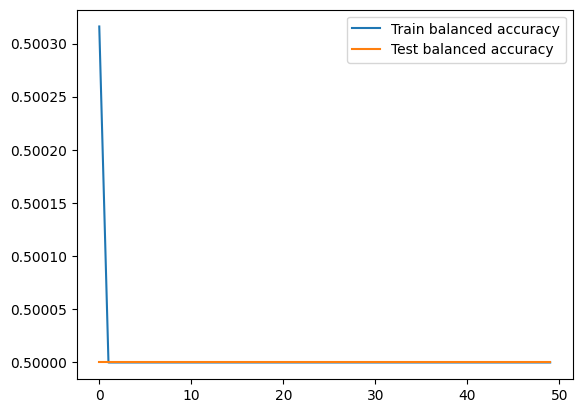

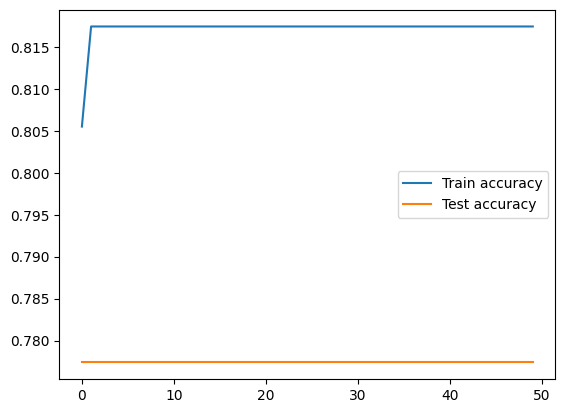

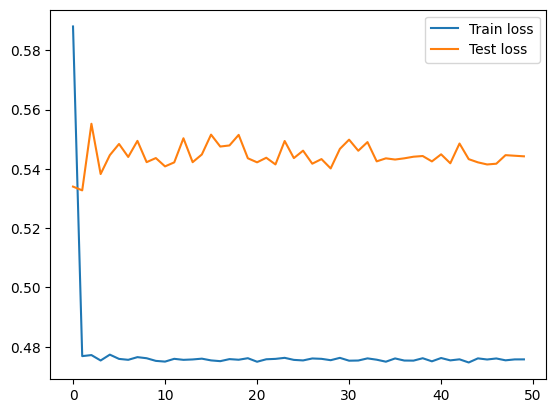

In [11]:
image_encoder = VGG16Encoder().to(device)
image_encoder.eval()
model = Classifier(d_model=25_088).to(device)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 50
trainer(
    model, image_encoder, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs,
    device=device, verbose=True, verbose_every=1, plot=True
)

In [12]:
y_true_val = np.array([labels_dict[p] for p in val_images.keys()])
y_pred_min = predict_all(
    model, image_encoder, val_images, transform_function, batch_size=batch_size, 
    prediction_aggregator=PredictionAggregator.MIN, device=device
)
y_pred_max = predict_all(
    model, image_encoder, val_images, transform_function, batch_size=batch_size, 
    prediction_aggregator=PredictionAggregator.MAX, device=device
)
y_pred_mean = predict_all(
    model, image_encoder, val_images, transform_function, batch_size=batch_size, 
    prediction_aggregator=PredictionAggregator.MEAN, device=device
)

In [13]:
acc = metrics.accuracy_score(y_true_val, y_pred_min)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred_min)
print(f"Min acc = {acc:.5f} bal. acc = {balanced_acc:.5f}")
acc = metrics.accuracy_score(y_true_val, y_pred_max)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred_max)
print(f"Max acc = {acc:.5f} bal. acc = {balanced_acc:.5f}")
acc = metrics.accuracy_score(y_true_val, y_pred_mean)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred_mean)
print(f"Mean acc = {acc:.5f} bal. acc = {balanced_acc:.5f}")

Min acc = 0.65854 bal. acc = 0.50000
Max acc = 0.65854 bal. acc = 0.50000
Mean acc = 0.65854 bal. acc = 0.50000
